In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/viktortorpthomsen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Increase sns font size
sns.set(font_scale=1.5)

# Functions

In [3]:
# implement a fuction to measure recovery
def recovery(df, col):
    """recovery is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained.
    """
    df = df.sort_values(by="position")
    df["local_min"] = df[col].cummin()
    df["recovery"] = df[col] - df["local_min"]
    # keep only the maximum recovery at each point
    # df["max_recovery"] = df["recovery"].cummax()
    # return df["max_recovery"]
    return df["recovery"]

In [4]:
# implement a fuction to measure recovery
def drawdown(df, col):
    """drawdown is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained.
    """
    df = df.sort_values(by="position")
    df["local_max"] = df[col].cummax()
    df["drawdown"] = df[col] - df["local_max"]
    # keep only the maximum recovery at each point
    # df["max_recovery"] = df["recovery"].cummax()
    # return df["max_recovery"]
    return df["drawdown"]

# GPT

In [5]:
gpt_u = pd.read_csv('../qa_predictions/20_total_documents/gpt/original_position_scores_uncertainity_accs.csv')
gpt_u_reorder = pd.read_csv('../qa_predictions/20_total_documents/gpt_reordered/original_position_scores_uncertainity_accs.csv')
gpt_u_tot = pd.read_csv('../qa_predictions/20_total_documents/gpt_tot/original_position_scores_uncertainity_accs.csv')
gpt_u_cot = pd.read_csv('../qa_predictions/20_total_documents/gpt_cot/original_position_scores_uncertainity_accs.csv')

In [6]:
gpt_u["model"] = "GPT"
gpt_u_reorder["model"] = "GPT"
gpt_u_tot["model"] = "GPT"
gpt_u_cot["model"] = "GPT"

gpt_u["method"] = "Vanilla RAG"
gpt_u_reorder["method"] = "Reordered"
gpt_u_tot["method"] = "Tree of Thought"
gpt_u_cot["method"] = "Chain of Thought"

gpt_unc = pd.concat([gpt_u, gpt_u_reorder, gpt_u_tot, gpt_u_cot])
gpt_unc["position"] = gpt_unc["position"] + 1

In [7]:
# Baseline results
gpt_closed = pd.read_csv('../qa_predictions/20_total_documents/gpt/closedbook_position_scores.csv')
gpt_closed["model"] = "GPT"
gpt_closed["method"] = "Vanilla RAG"
gpt_closed["baseline"] = "Closed Book"
gpt_oracle = pd.read_csv('../qa_predictions/20_total_documents/gpt/oracle_position_scores.csv')
gpt_oracle["model"] = "GPT"
gpt_oracle["method"] = "Vanilla RAG"
gpt_oracle["baseline"] = "Oracle"

gpt_tot_closed = pd.read_csv('../qa_predictions/20_total_documents/gpt_tot/closedbook_position_scores.csv')
gpt_tot_closed["model"] = "GPT"
gpt_tot_closed["method"] = "Tree of Thought"
gpt_tot_closed["baseline"] = "Closed Book"
gpt_tot_oracle = pd.read_csv('../qa_predictions/20_total_documents/gpt_tot/oracle_position_scores.csv')
gpt_tot_oracle["model"] = "GPT"
gpt_tot_oracle["method"] = "Tree of Thought"
gpt_tot_oracle["baseline"] = "Oracle"

gpt_cot_closed = pd.read_csv('../qa_predictions/20_total_documents/gpt_cot/closedbook_position_scores.csv')
gpt_cot_closed["model"] = "GPT"
gpt_cot_closed["method"] = "Chain of Thought"
gpt_cot_closed["baseline"] = "Closed Book"
gpt_cot_oracle = pd.read_csv('../qa_predictions/20_total_documents/gpt_cot/oracle_position_scores.csv')
gpt_cot_oracle["model"] = "GPT"
gpt_cot_oracle["method"] = "Chain of Thought"
gpt_cot_oracle["baseline"] = "Oracle"


gpt_baselines = pd.concat([gpt_closed, gpt_oracle, gpt_tot_closed, gpt_tot_oracle, gpt_cot_closed, gpt_cot_oracle])
gpt_baselines.rename(columns={"metric": "accuracy"}, inplace=True)

In [8]:
gpt_mins = gpt_unc.groupby(["model", "method", "position"])["accuracy"].mean().groupby(["model", "method"]).cummin().reset_index()

In [9]:
methods = ["Vanilla RAG", "Reordered", "Tree of Thought", "Chain of Thought"]
colors = sns.color_palette("deep", len(methods))
methods_palette = dict(zip(methods, colors))

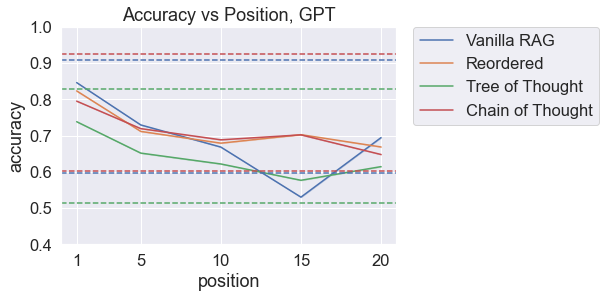

In [10]:
fig = sns.lineplot(data=gpt_unc, x="position", y="accuracy", hue="method", errorbar=("ci", 99), palette=methods_palette)
# Plot horizontal line from baselines
for method in methods:
    if method == "Reordered":
        continue
    cb = gpt_baselines[(gpt_baselines["method"] == method) & (gpt_baselines["baseline"] == "Closed Book")]
    oracle = gpt_baselines[(gpt_baselines["method"] == method) & (gpt_baselines["baseline"] == "Oracle")]
    fig.axhline(y=cb["accuracy"].values[0], color=methods_palette[method], linestyle='--')
    fig.axhline(y=oracle["accuracy"].values[0], color=methods_palette[method], linestyle='--')


# sns.lineplot(data=gpt_mins, x="position", y="accuracy", hue="method", legend=False, linestyle="dashed")
plt.title("Accuracy vs Position, GPT")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
# Increase y axis range
plt.ylim(0.4, 1.0)

plt.show()

In [11]:
gpt_agg = gpt_unc.groupby(["model", "method", "position"]).mean().reset_index()

In [12]:
gpt_agg["recovery"] = gpt_agg.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
gpt_agg["max_recovery"] = gpt_agg.groupby(["model", "method"])["recovery"].cummax()
gpt_agg["drawdown"] = gpt_agg.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
gpt_agg["max_drawdown"] = gpt_agg.groupby(["model", "method"])["drawdown"].cummin()


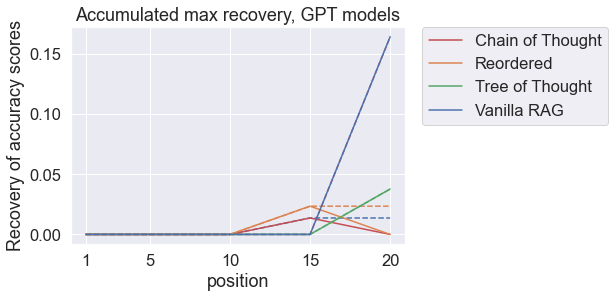

In [13]:
# plot recovery and accuracy 
# sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
sns.lineplot(data=gpt_agg, x="position", y="max_recovery", hue="method", palette="deep",linestyle='dashed', legend=False)
sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method", palette=methods_palette)

plt.title("Accumulated max recovery, GPT models")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.ylabel("Recovery of accuracy scores")
plt.show()

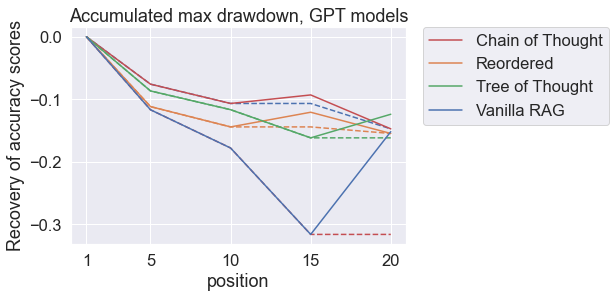

In [14]:
# plot recovery and accuracy 
# sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
sns.lineplot(data=gpt_agg, x="position", y="max_drawdown", hue="method", palette="deep",linestyle='dashed', legend=False)
sns.lineplot(data=gpt_agg, x="position", y="drawdown", hue="method", palette=methods_palette)

plt.title("Accumulated max drawdown, GPT models")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.ylabel("Recovery of accuracy scores")
plt.show()

# Llama

In [15]:
llama_u = pd.read_csv('../qa_predictions/20_total_documents/llama/original_position_scores_uncertainity_accs.csv')
llama_u_reorder = pd.read_csv('../qa_predictions/20_total_documents/llama_reordered/original_position_scores_uncertainity_accs.csv')
llama_u_reorder_k10 = pd.read_csv('../qa_predictions/20_total_documents/llama_reordered_k10/original_position_scores_uncertainity_accs.csv')
llama_u_tot = pd.read_csv('../qa_predictions/20_total_documents/llama_tot/original_position_scores_uncertainity_accs.csv')
llama_u_cot = pd.read_csv('../qa_predictions/20_total_documents/llama_cot/original_position_scores_uncertainity_accs.csv')

In [16]:
llama_u["model"] = "Llama"
llama_u_reorder["model"] = "Llama"
llama_u_reorder_k10["model"] = "Llama"
llama_u_tot["model"] = "Llama"
llama_u_cot["model"] = "Llama"

llama_u["method"] = "Vanilla RAG"
llama_u_reorder["method"] = "Reordered"
llama_u_reorder_k10["method"] = "Reorderded k=10"
llama_u_tot["method"] = "Tree of Thought"
llama_u_cot["method"] = "Chain of Thought"

llama_unc = pd.concat([llama_u, llama_u_reorder, llama_u_tot, llama_u_cot])
llama_unc["position"] = llama_unc["position"] + 1

In [17]:
# # Baseline results
# llama_closed = pd.read_csv('../qa_predictions/20_total_documents/llama/closedbook_position_scores.csv')
# llama_closed["model"] = "Llama"
# llama_closed["method"] = "Vanilla RAG"
# llama_closed["baseline"] = "Closed Book"
# llama_oracle = pd.read_csv('../qa_predictions/20_total_documents/llama/oracle_position_scores.csv')
# llama_oracle["model"] = "Llama"
# llama_oracle["method"] = "Vanilla RAG"
# llama_oracle["baseline"] = "Oracle"

# llama_tot_closed = pd.read_csv('../qa_predictions/20_total_documents/llama_tot/closedbook_position_scores.csv')
# llama_tot_closed["model"] = "Llama"
# llama_tot_closed["method"] = "Tree of Thought"
# llama_tot_closed["baseline"] = "Closed Book"
# llama_tot_oracle = pd.read_csv('../qa_predictions/20_total_documents/llama_tot/oracle_position_scores.csv')
# llama_tot_oracle["model"] = "Llama"
# llama_tot_oracle["method"] = "Tree of Thought"
# llama_tot_oracle["baseline"] = "Oracle"

# llama_cot_closed = pd.read_csv('../qa_predictions/20_total_documents/llama_COT/closedbook_position_scores.csv')
# llama_COT_closed["model"] = "Llama"
# llama_cot_closed["method"] = "Chain of Thought"
# llama_cot_closed["baseline"] = "Closed Book"
# llama_cot_oracle = pd.read_csv('../qa_predictions/20_total_documents/llama_COT/oracle_position_scores.csv')
# llama_cot_oracle["model"] = "Llama"
# llama_cot_oracle["method"] = "Chain of Thought"
# llama_cot_oracle["baseline"] = "Oracle"


# llama_baselines = pd.concat([llama_closed, llama_oracle, llama_tot_closed, llama_tot_oracle, llama_cot_closed, llama_cot_oracle])
# llama_baselines.rename(columns={"metric": "accuracy"}, inplace=True)

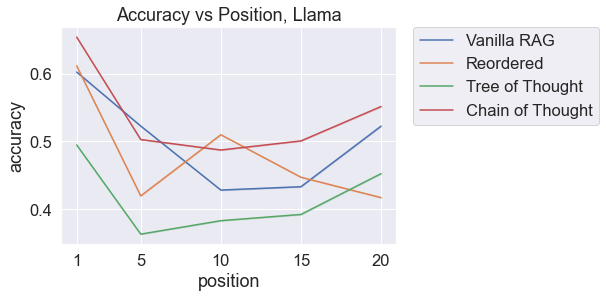

In [18]:
sns.lineplot(data=llama_unc, x="position", y="accuracy", hue="method", errorbar=("ci", 99), palette=methods_palette)
plt.title("Accuracy vs Position, Llama")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.show()

In [19]:
llama_agg = llama_unc.groupby(["model", "method", "position"]).mean().reset_index()


In [20]:
llama_agg["recovery"] = llama_agg.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
llama_agg["max_recovery"] = llama_agg.groupby(["model", "method"])["recovery"].cummax()


In [21]:
llama_agg["drawdown"] = llama_agg.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
llama_agg["max_drawdown"] = llama_agg.groupby(["model", "method"])["drawdown"].cummin()

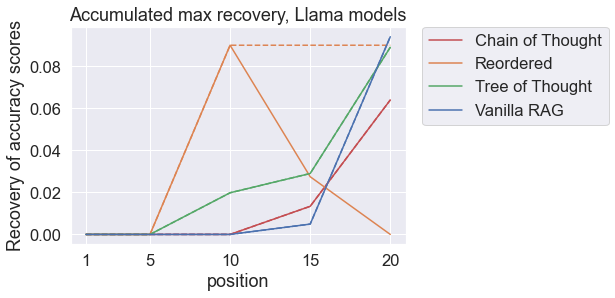

In [22]:
# plot recovery and accuracy 
# sns.lineplot(data=llama_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
sns.lineplot(data=llama_agg, x="position", y="max_recovery", hue="method", palette=methods_palette,linestyle='dashed', legend=False)
sns.lineplot(data=llama_agg, x="position", y="recovery", hue="method", palette=methods_palette)

plt.title("Accumulated max recovery, Llama models")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.ylabel("Recovery of accuracy scores")
plt.show()

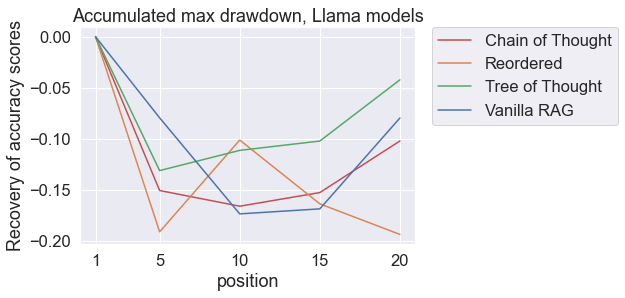

In [23]:
# plot recovery and accuracy 
# sns.lineplot(data=llama_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
# sns.lineplot(data=llama_agg, x="position", y="max_drawdown", hue="method", palette=methods_palette,linestyle='dashed', legend=False)
sns.lineplot(data=llama_agg, x="position", y="drawdown", hue="method", palette=methods_palette)

plt.title("Accumulated max drawdown, Llama models")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.ylabel("Recovery of accuracy scores")
plt.show()

# Llama 70B

In [24]:
llama_70b_u = pd.read_csv('../qa_predictions/20_total_documents/llama_70b/original_position_scores_uncertainity_accs.csv')
llama_70b_u_reorder = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_reordered/original_position_scores_uncertainity_accs.csv')
llama_70b_u_tot = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_tot/original_position_scores_uncertainity_accs.csv')
llama_70b_u_cot = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_cot/original_position_scores_uncertainity_accs.csv')

In [25]:
llama_70b_u["model"] = "Llama 70B"
llama_70b_u_reorder["model"] = "Llama 70B"
llama_70b_u_tot["model"] = "Llama 70B"
llama_70b_u_cot["model"] = "Llama 70B"

llama_70b_u["method"] = "Vanilla RAG"
llama_70b_u_reorder["method"] = "Reordered"
llama_70b_u_tot["method"] = "Tree of Thought"
llama_70b_u_cot["method"] = "Chain of Thought"

llama_70b_unc = pd.concat([llama_70b_u, llama_70b_u_reorder, llama_70b_u_tot, llama_70b_u_cot])
llama_70b_unc["position"] = llama_70b_unc["position"] + 1

In [26]:
# Baseline results
llama_70b_closed = pd.read_csv('../qa_predictions/20_total_documents/llama_70b/closedbook_position_scores.csv')
llama_70b_closed["model"] = "Llama 70B"
llama_70b_closed["method"] = "Vanilla RAG"
llama_70b_closed["baseline"] = "Closed Book"
llama_70b_oracle = pd.read_csv('../qa_predictions/20_total_documents/llama_70b/oracle_position_scores.csv')
llama_70b_oracle["model"] = "Llama 70B"
llama_70b_oracle["method"] = "Vanilla RAG"
llama_70b_oracle["baseline"] = "Oracle"

# llama_70b_tot_closed = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_tot/closedbook_position_scores.csv')
# llama_70b_tot_closed["model"] = "Llama_70b"
# llama_70b_tot_closed["method"] = "Tree of Thought"
# llama_70b_tot_closed["baseline"] = "Closed Book"
# llama_70b_tot_oracle = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_tot/oracle_position_scores.csv')
# llama_70b_tot_oracle["model"] = "Llama_70b"
# llama_70b_tot_oracle["method"] = "Tree of Thought"
# llama_70b_tot_oracle["baseline"] = "Oracle"

llama_70b_cot_closed = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_COT/closedbook_position_scores.csv')
llama_70b_cot_closed["model"] = "Llama 70B"
llama_70b_cot_closed["method"] = "Chain of Thought"
llama_70b_cot_closed["baseline"] = "Closed Book"
llama_70b_cot_oracle = pd.read_csv('../qa_predictions/20_total_documents/llama_70b_COT/oracle_position_scores.csv')
llama_70b_cot_oracle["model"] = "Llama 70B"
llama_70b_cot_oracle["method"] = "Chain of Thought"
llama_70b_cot_oracle["baseline"] = "Oracle"


llama_70b_baselines = pd.concat([llama_70b_closed, llama_70b_oracle, llama_70b_cot_closed, llama_70b_cot_oracle])
llama_70b_baselines.rename(columns={"metric": "accuracy"}, inplace=True)

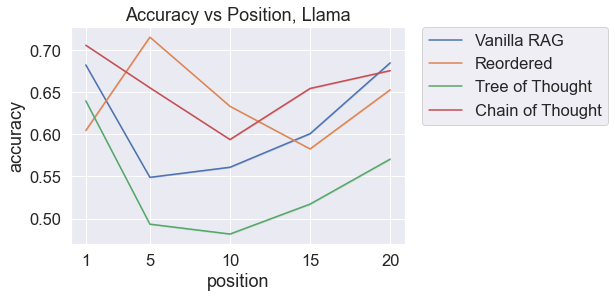

In [27]:
sns.lineplot(data=llama_70b_unc, x="position", y="accuracy", hue="method", errorbar=("ci", 99), palette=methods_palette)
plt.title("Accuracy vs Position, Llama")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.show()

In [28]:
llama_70b_unc = llama_70b_unc.groupby(["model", "method", "position"]).mean().reset_index()


In [29]:
llama_70b_unc["recovery"] = llama_70b_unc.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
llama_70b_unc["max_recovery"] = llama_70b_unc.groupby(["model", "method"])["recovery"].cummax()

llama_70b_unc["drawdown"] = llama_70b_unc.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
llama_70b_unc["max_drawdown"] = llama_70b_unc.groupby(["model", "method"])["drawdown"].cummin()

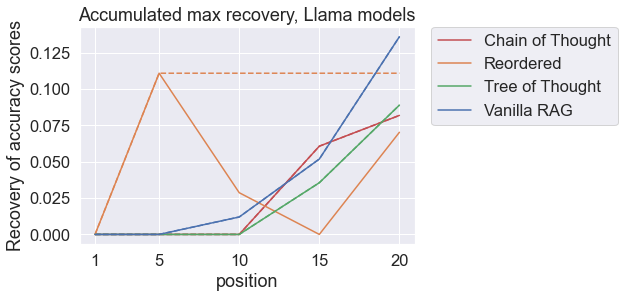

In [30]:
# plot recovery and accuracy 
# sns.lineplot(data=llama_70b_unc, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
sns.lineplot(data=llama_70b_unc, x="position", y="max_recovery", hue="method", palette=methods_palette, legend=False,linestyle='dashed')
sns.lineplot(data=llama_70b_unc, x="position", y="recovery", hue="method", palette=methods_palette)
# plot horizontal line with the maximum accuracy
# Add dashed linestyle to the legend
plt.title("Accumulated max recovery, Llama models")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.ylabel("Recovery of accuracy scores")
plt.show()

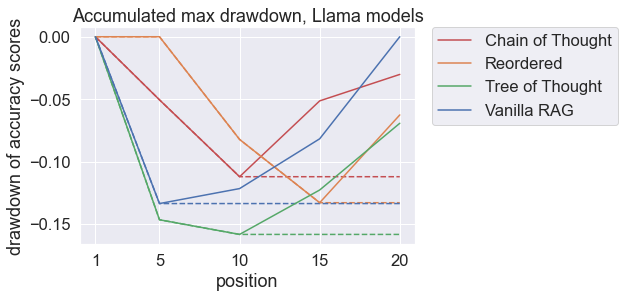

In [31]:
# plot recovery and accuracy 
# sns.lineplot(data=llama_70b_unc, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
sns.lineplot(data=llama_70b_unc, x="position", y="max_drawdown", hue="method", palette=methods_palette, legend=False,linestyle='dashed')
sns.lineplot(data=llama_70b_unc, x="position", y="drawdown", hue="method", palette=methods_palette)
# plot horizontal line with the maximum accuracy
# Add dashed linestyle to the legend
plt.title("Accumulated max drawdown, Llama models")
# Set legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#set x axis ticks
plt.xticks([1,5,10,15,20])
plt.ylabel("drawdown of accuracy scores")
plt.show()

# Model comparrison

In [32]:
reg_df = pd.concat([gpt_u, llama_u, llama_70b_u])
reg_df["position"] = reg_df["position"] + 1

In [33]:
baseline_df = pd.concat([gpt_baselines, llama_70b_baselines])

In [34]:
baseline_df["position"] = baseline_df["position"] + 1

In [35]:
avg_baseline = baseline_df.groupby(["method", "baseline"]).mean().reset_index()
avg_baseline["model"] = "Average"
baseline_df = pd.concat([baseline_df, avg_baseline])

In [36]:
baseline_df

,position,accuracy,model,method,baseline
0,1.0,0.596610,GPT,Vanilla RAG,Closed Book
0,1.0,0.909228,GPT,Vanilla RAG,Oracle
0,1.0,0.512994,GPT,Tree of Thought,Closed Book
0,1.0,0.829379,GPT,Tree of Thought,Oracle
0,1.0,0.603013,GPT,Chain of Thought,Closed Book
0,1.0,0.926177,GPT,Chain of Thought,Oracle
0,1.0,0.494175,Llama 70B,Vanilla RAG,Closed Book
0,1.0,0.904708,Llama 70B,Vanilla RAG,Oracle
0,1.0,0.507345,Llama 70B,Chain of Thought,Closed Book
0,1.0,0.929190,Llama 70B,Chain of Thought,Oracle


In [37]:
models = ["GPT", "Llama", "Llama 70B", "Average"]
colors = sns.color_palette("deep", len(models))
models_palette = dict(zip(models, colors))

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_74190/1994509014.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.lineplot(data=reg_df, x="position", y="accuracy", errorbar=("ci", 99), label="Average", palette=models_palette, ax=fig)


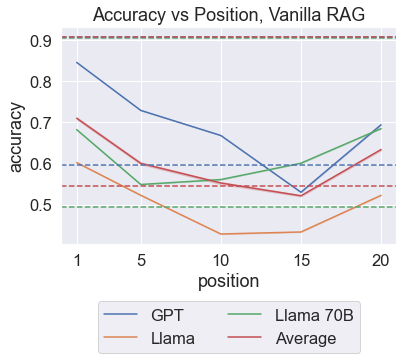

In [38]:
fig = sns.lineplot(data=reg_df, x="position", y="accuracy", hue="model", errorbar=("ci", 99), palette=models_palette)
fig = sns.lineplot(data=reg_df, x="position", y="accuracy", errorbar=("ci", 99), label="Average", palette=models_palette, ax=fig)

# Plot horizontal line from baselines
for model in ["GPT", "Llama 70B", "Average"]:
    cb = baseline_df[(baseline_df["model"] == model) & (baseline_df["baseline"] == "Closed Book") & (baseline_df["method"] == "Vanilla RAG")]
    oracle = baseline_df[(baseline_df["model"] == model) & (baseline_df["baseline"] == "Oracle") & (baseline_df["method"] == "Vanilla RAG")]
    fig.axhline(y=cb["accuracy"].values[0], color=models_palette[model], linestyle='--')
    fig.axhline(y=oracle["accuracy"].values[0], color=models_palette[model], linestyle='--')
# sns.lineplot(data=gpt_mins, x="position", y="accuracy", hue="method", legend=False, linestyle="dashed")
fig.set_title("Accuracy vs Position, Vanilla RAG")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig = fig.get_figure()
fig.savefig("figs/LIM_accuracy_vs_position.png", bbox_inches="tight")

In [39]:
reg_df = reg_df.groupby(["model", "method", "position"]).mean().reset_index()

In [40]:
reg_df["recovery"] = reg_df.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
reg_df["max_recovery"] = reg_df.groupby(["model", "method"])["recovery"].cummax()
reg_df["drawdown"] = reg_df.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
reg_df["max_drawdown"] = reg_df.groupby(["model", "method"])["drawdown"].cummin()


/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_74190/3303957867.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.lineplot(data=reg_df, x="position", y="recovery", palette=models_palette, label="Average", ax=fig)


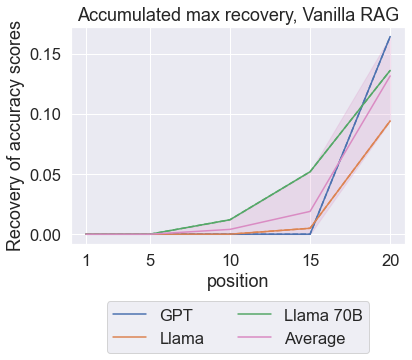

In [41]:
# plot recovery and accuracy 
# sns.lineplot(data=reg_df, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=reg_df, x="position", y="max_recovery", hue="model", palette=models_palette,linestyle='dashed', legend=False)
fig = sns.lineplot(data=reg_df, x="position", y="recovery", hue="model", palette=models_palette, ax=fig)
fig = sns.lineplot(data=reg_df, x="position", y="recovery", palette=models_palette, label="Average", ax=fig)


fig.set_title("Accumulated max recovery, Vanilla RAG")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/LIM_max_recovery.png", bbox_inches="tight")

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_74190/1744399079.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.lineplot(data=reg_df, x="position", y="drawdown",  palette=models_palette, legend=False, label="Average", ax=fig)


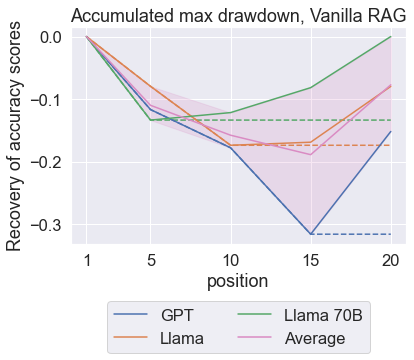

In [42]:
# plot recovery and accuracy 
# sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=reg_df, x="position", y="max_drawdown", hue="model", palette=models_palette,linestyle='dashed', legend=False)
fig = sns.lineplot(data=reg_df, x="position", y="drawdown", hue="model", palette=models_palette, ax=fig)
fig = sns.lineplot(data=reg_df, x="position", y="drawdown",  palette=models_palette, legend=False, label="Average", ax=fig)

fig.set_title("Accumulated max drawdown, Vanilla RAG")
# Set legend beneath the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/LIM_drawdown.png", bbox_inches="tight")

## Reordering

In [44]:
reo_df = pd.concat([gpt_u_reorder, llama_u_reorder,llama_70b_u_reorder])
reo_df["position"] = reo_df["position"] + 1
reo_df = pd.concat([reo_df, reg_df])

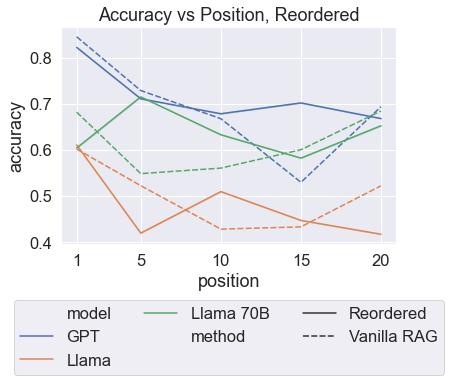

In [45]:
fig = sns.lineplot(data=reo_df, x="position", y="accuracy", hue="model", style="method", errorbar=("ci", 99), palette=models_palette)
#fig = sns.lineplot(data=reo_df, x="position", y="accuracy", label="Average", color=models_palette["Average"], ax=fig, errorbar=None)
# sns.lineplot(data=gpt_mins, x="position", y="accuracy", hue="method", legend=False, linestyle="dashed")
fig.set_title("Accuracy vs Position, Reordered")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.6), ncols=3, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
plt.show()
fig = fig.get_figure()
fig.savefig("figs/reordered_acc.png", bbox_inches="tight")

In [46]:
reo_df = reo_df.groupby(["model", "method", "position"]).mean().reset_index()

In [47]:
reo_df["recovery"] = reo_df.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
reo_df["max_recovery"] = reo_df.groupby(["model", "method"])["recovery"].cummax()
reo_df["drawdown"] = reo_df.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
reo_df["max_drawdown"] = reo_df.groupby(["model", "method"])["drawdown"].cummin()


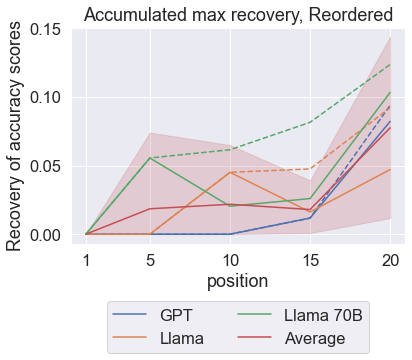

In [48]:
# plot recovery and accuracy 
# sns.lineplot(data=reo_df, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=reo_df, x="position", y="max_recovery", hue="model",palette=models_palette,linestyle='dashed', legend=False, errorbar=None)
fig = sns.lineplot(data=reo_df, x="position", y="recovery", hue="model" , palette=models_palette, ax=fig, errorbar=None)
fig = sns.lineplot(data=reo_df, x="position", y="recovery", errorbar=("ci", 99), label="Average", color=models_palette["Average"], ax=fig)

fig.set_title("Accumulated max recovery, Reordered")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/reordered_recovery.png", bbox_inches="tight")

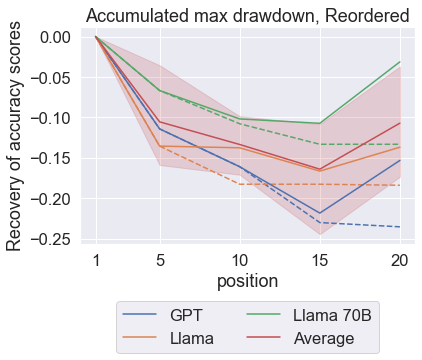

In [49]:
# plot recovery and accuracy 
# sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=reo_df, x="position", y="max_drawdown", hue="model", palette=models_palette,linestyle='dashed', legend=False, errorbar=None)
fig = sns.lineplot(data=reo_df, x="position", y="drawdown", hue="model", palette=models_palette, ax=fig, errorbar=None)
fig = sns.lineplot(data=reo_df, x="position", y="drawdown", errorbar=("ci", 99), label="Average", color=models_palette["Average"], ax=fig)

fig.set_title("Accumulated max drawdown, Reordered")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/reordered_drawdown.png", bbox_inches="tight")

## COT

In [50]:
cot_df = pd.concat([gpt_u_cot, llama_u_cot,llama_70b_u_cot])
cot_df["position"] = cot_df["position"] + 1
cot_df = pd.concat([cot_df, reg_df])

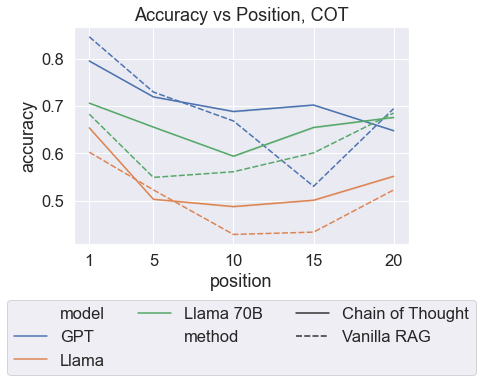

In [51]:
fig = sns.lineplot(data=cot_df, x="position", y="accuracy", hue="model", style="method", errorbar=("ci", 99))
# fig = sns.lineplot(data=cot_df, x="position", y="accuracy", errorbar=("ci", 99), label="Average")

# sns.lineplot(data=gpt_mins, x="position", y="accuracy", hue="method", legend=False, linestyle="dashed")
fig.set_title("Accuracy vs Position, COT")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.6), ncols=3, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
plt.show()
fig = fig.get_figure()
fig.savefig("figs/cot_acc.png", bbox_inches="tight")

In [52]:
cot_df = cot_df.groupby(["model", "method", "position"]).mean().reset_index()

In [53]:
cot_df["recovery"] = cot_df.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
cot_df["max_recovery"] = cot_df.groupby(["model", "method"])["recovery"].cummax()
cot_df["drawdown"] = cot_df.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
cot_df["max_drawdown"] = cot_df.groupby(["model", "method"])["drawdown"].cummin()


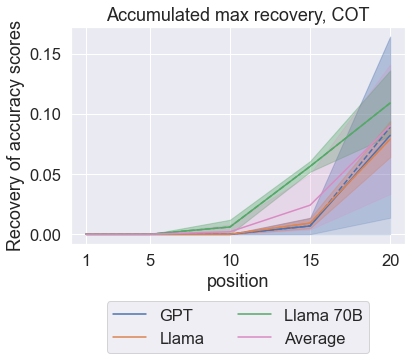

In [54]:
# plot recovery and accuracy 
# sns.lineplot(data=cot_df, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=cot_df, x="position", y="max_recovery", hue="model",palette="deep",linestyle='dashed', legend=False)
fig = sns.lineplot(data=cot_df, x="position", y="recovery", hue="model" ,palette="deep", ax=fig)
fig = sns.lineplot(data=cot_df, x="position", y="recovery", errorbar=("ci", 99), label="Average", ax=fig)

fig.set_title("Accumulated max recovery, COT")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)

#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/cot_recovery.png", bbox_inches="tight")

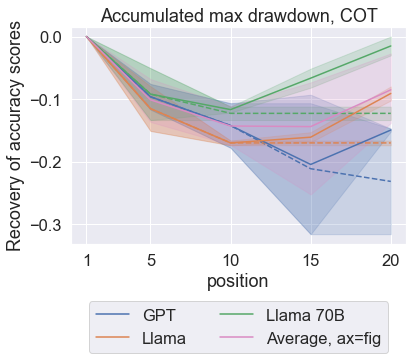

In [55]:
# plot recovery and accuracy 
# sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=cot_df, x="position", y="max_drawdown", hue="model", palette="deep",linestyle='dashed', legend=False)
fig = sns.lineplot(data=cot_df, x="position", y="drawdown", hue="model", palette="deep", ax=fig)
fig = sns.lineplot(data=cot_df, x="position", y="drawdown", errorbar=("ci", 99), label="Average, ax=fig")

fig.set_title("Accumulated max drawdown, COT")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/cot_drawdown.png", bbox_inches="tight")

In [56]:
cot_df

,model,method,position,accuracy,recovery,max_recovery,drawdown,max_drawdown
0,GPT,Chain of Thought,1,0.795064,0.000000,0.000000,0.000000,0.000000
1,GPT,Chain of Thought,5,0.719249,0.000000,0.000000,-0.075815,-0.075815
2,GPT,Chain of Thought,10,0.688377,0.000000,0.000000,-0.106687,-0.106687
3,GPT,Chain of Thought,15,0.702033,0.013656,0.013656,-0.093031,-0.106687
4,GPT,Chain of Thought,20,0.647814,0.000000,0.013656,-0.147249,-0.147249
5,GPT,Vanilla RAG,1,0.846197,0.000000,0.000000,0.000000,0.000000
6,GPT,Vanilla RAG,5,0.729425,0.000000,0.000000,-0.116772,-0.116772
7,GPT,Vanilla RAG,10,0.668312,0.000000,0.000000,-0.177885,-0.177885
8,GPT,Vanilla RAG,15,0.530158,0.000000,0.000000,-0.316040,-0.316040
9,GPT,Vanilla RAG,20,0.694396,0.164238,0.164238,-0.151801,-0.316040


## TOT

In [57]:
tot_df = pd.concat([gpt_u_tot, llama_u_tot,llama_70b_u_tot])
tot_df["position"] = tot_df["position"] + 1

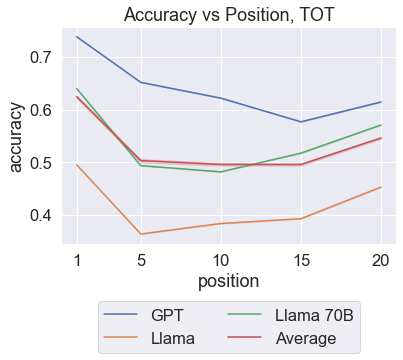

In [58]:
fig = sns.lineplot(data=tot_df, x="position", y="accuracy", hue="model", errorbar=("ci", 99))
fig = sns.lineplot(data=tot_df, x="position", y="accuracy", errorbar=("ci", 99), label="Average", ax=fig)
# sns.lineplot(data=gpt_mins, x="position", y="accuracy", hue="method", legend=False, linestyle="dashed")
fig.set_title("Accuracy vs Position, TOT")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
plt.show()
fig = fig.get_figure()
fig.savefig("figs/tot_acc.png", bbox_inches="tight")

In [59]:
tot_df = tot_df.groupby(["model", "method", "position"]).mean().reset_index()

In [60]:
tot_df["recovery"] = tot_df.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
tot_df["max_recovery"] = tot_df.groupby(["model", "method"])["recovery"].cummax()
tot_df["drawdown"] = tot_df.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
tot_df["max_drawdown"] = tot_df.groupby(["model", "method"])["drawdown"].cummin()


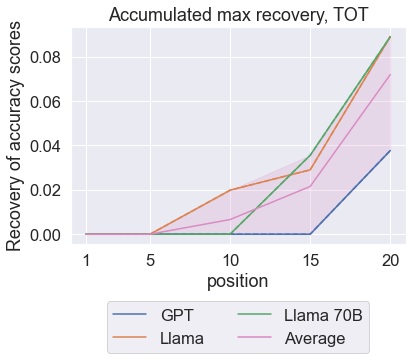

In [61]:
# plot recovery and accuracy 
# sns.lineplot(data=tot_df, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=tot_df, x="position", y="max_recovery", hue="model",palette="deep",linestyle='dashed', legend=False)
fig = sns.lineplot(data=tot_df, x="position", y="recovery", hue="model" ,palette="deep", ax=fig)
fig = sns.lineplot(data=tot_df, x="position", y="recovery", errorbar=("ci", 99), label="Average", ax=fig)

fig.set_title("Accumulated max recovery, TOT")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/tot_recovery.png", bbox_inches="tight")

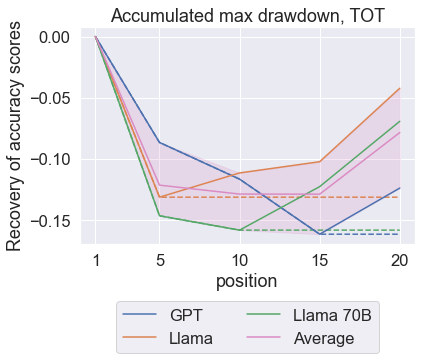

In [62]:
# plot recovery and accuracy 
# sns.lineplot(data=gpt_agg, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=tot_df, x="position", y="max_drawdown", hue="model", palette="deep",linestyle='dashed', legend=False)
fig = sns.lineplot(data=tot_df, x="position", y="drawdown", hue="model", palette="deep", ax=fig)
fig = sns.lineplot(data=tot_df, x="position", y="drawdown", errorbar=("ci", 99), label="Average", ax=fig)

fig.set_title("Accumulated max drawdown, TOT")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/tot_drawdown.png", bbox_inches="tight")

## All in all

In [63]:
#baselines = pd.concat([gpt_baselines, llama_baselines, llama_70b_baselines])
baselines = pd.concat([gpt_baselines, llama_70b_baselines])
baselines["position"] = baselines["position"] + 1

In [64]:
baselines

,position,accuracy,model,method,baseline
0,1,0.596610,GPT,Vanilla RAG,Closed Book
0,1,0.909228,GPT,Vanilla RAG,Oracle
0,1,0.512994,GPT,Tree of Thought,Closed Book
0,1,0.829379,GPT,Tree of Thought,Oracle
0,1,0.603013,GPT,Chain of Thought,Closed Book
0,1,0.926177,GPT,Chain of Thought,Oracle
0,1,0.494175,Llama 70B,Vanilla RAG,Closed Book
0,1,0.904708,Llama 70B,Vanilla RAG,Oracle
0,1,0.507345,Llama 70B,Chain of Thought,Closed Book
0,1,0.929190,Llama 70B,Chain of Thought,Oracle


In [65]:
gdf_baselines = baselines.groupby(["method", "baseline"]).mean().reset_index()
gdf_baselines

,method,baseline,position,accuracy
0,Chain of Thought,Closed Book,1.0,0.555179
1,Chain of Thought,Oracle,1.0,0.927684
2,Tree of Thought,Closed Book,1.0,0.512994
3,Tree of Thought,Oracle,1.0,0.829379
4,Vanilla RAG,Closed Book,1.0,0.545393
5,Vanilla RAG,Oracle,1.0,0.906968


In [66]:
all_df = pd.concat([gpt_u_tot, llama_u_tot,llama_70b_u_tot, gpt_u_cot, llama_u_cot,llama_70b_u_cot,gpt_u, llama_u,llama_70b_u, gpt_u_reorder, llama_u_reorder,llama_70b_u_reorder, gpt_u, llama_u,llama_70b_u])
all_df["position"] = all_df["position"] + 1

In [67]:
all_df["method"] = all_df["method"].apply(lambda x: x.replace("Reorder k=5", "Reorder"))

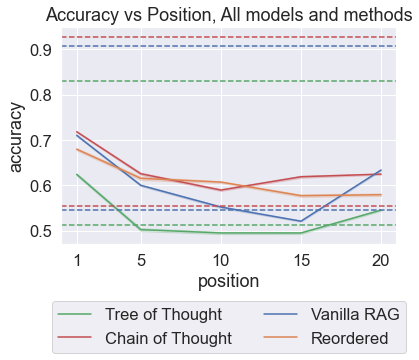

In [68]:
fig = sns.lineplot(data=all_df, x="position", y="accuracy", hue="method", errorbar=("ci", 99), palette=methods_palette)
for method in methods:
    if method == "Reordered":
        continue
    cb = gdf_baselines[(gdf_baselines["method"] == method) & (gdf_baselines["baseline"] == "Closed Book")]
    oracle = gdf_baselines[(gdf_baselines["method"] == method) & (gdf_baselines["baseline"] == "Oracle")]
    fig.axhline(y=cb["accuracy"].values[0], color=methods_palette[method], linestyle='--')
    fig.axhline(y=oracle["accuracy"].values[0], color=methods_palette[method], linestyle='--')
# sns.lineplot(data=gpt_mins, x="position", y="accuracy", hue="method", legend=False, linestyle="dashed")
fig.set_title("Accuracy vs Position, All models and methods")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
plt.show()
fig = fig.get_figure()
fig.savefig("figs/all_models_acc.png", bbox_inches="tight")

In [69]:
all_df = all_df.groupby(["model", "method", "position"]).mean().reset_index()

In [70]:
all_df["recovery"] = all_df.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
all_df["max_recovery"] = all_df.groupby(["model", "method"])["recovery"].cummax()
all_df["drawdown"] = all_df.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
all_df["max_drawdown"] = all_df.groupby(["model", "method"])["drawdown"].cummin()


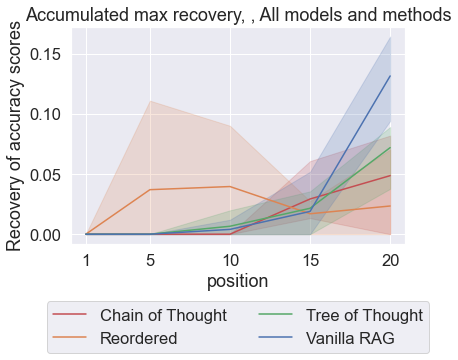

In [71]:
# plot recovery and accuracy 
# sns.lineplot(data=tot_df, x="position", y="recovery", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=all_df, x="position", y="recovery", hue="method",palette=methods_palette, errorbar=("ci", 99))
fig.set_title("Accumulated max recovery, , All models and methods")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("Recovery of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/all_models_recovery.png", bbox_inches="tight")

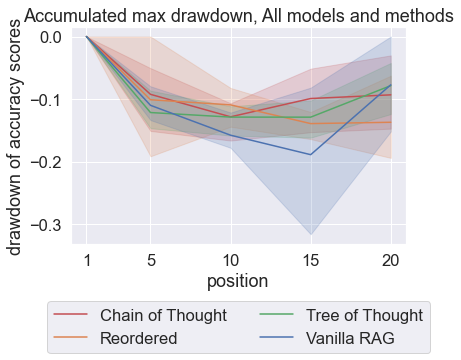

In [72]:
# plot drawdown and accuracy 
# sns.lineplot(data=tot_df, x="position", y="drawdown", hue="method")
# Plot max recovery with the same color as the corresponding recovery
fig = sns.lineplot(data=all_df, x="position", y="drawdown", hue="method", palette=methods_palette, errorbar=("ci", 99))

fig.set_title("Accumulated max drawdown, All models and methods")
# Set legend outside the figure
fig.legend(loc="lower center",bbox_to_anchor=(.5, -.5), ncols=2, borderaxespad=0.)
#set x axis ticks
fig.set_xticks([1,5,10,15,20])
fig.set_ylabel("drawdown of accuracy scores")
plt.show()
fig = fig.get_figure()
fig.savefig("figs/all_models_drawdown.png", bbox_inches="tight")

In [73]:
all_df = pd.concat([gpt_u_tot, llama_u_tot,llama_70b_u_tot, gpt_u_cot, llama_u_cot,llama_70b_u_cot,gpt_u, llama_u,llama_70b_u, gpt_u_reorder, llama_u_reorder,llama_70b_u_reorder, gpt_u, llama_u,llama_70b_u])
all_df["position"] = all_df["position"] + 1
all_df["method"] = all_df["method"].apply(lambda x: x.replace("Reorder k=5", "Reorder"))


In [75]:
all_df = all_df.groupby(["model", "method", "position"]).mean().reset_index()
all_df["recovery"] = all_df.groupby(["model", "method"]).apply(recovery, "accuracy").rename("recovery").reset_index()["recovery"]
all_df["max_recovery"] = all_df.groupby(["model", "method"])["recovery"].cummax()
all_df["drawdown"] = all_df.groupby(["model", "method"]).apply(drawdown, "accuracy").rename("drawdown").reset_index()["drawdown"]
all_df["max_drawdown"] = all_df.groupby(["model", "method"])["drawdown"].cummin()


In [76]:
agg_results = all_df.groupby(["model", "method"]).mean().reset_index()
print(agg_results[["model", "method", "accuracy", "recovery", "drawdown", "max_recovery", "max_drawdown"]].rename(columns={"max_drawdown":"min_drawdown"}).to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
    model &           method &  accuracy &  recovery &  drawdown &  max\_recovery &  min\_drawdown \\
\midrule
      GPT & Chain of Thought &  0.710507 &  0.002731 & -0.084557 &      0.005462 &     -0.087288 \\
      GPT &        Reordered &  0.717018 &  0.004691 & -0.106239 &      0.009383 &     -0.110931 \\
      GPT &  Tree of Thought &  0.640544 &  0.007545 & -0.097769 &      0.007545 &     -0.105314 \\
      GPT &      Vanilla RAG &  0.693698 &  0.032848 & -0.152500 &      0.032848 &     -0.185347 \\
    Llama & Chain of Thought &  0.539282 &  0.015480 & -0.114505 &      0.015480 &     -0.129985 \\
    Llama &        Reordered &  0.481170 &  0.023511 & -0.130184 &      0.054048 &     -0.153694 \\
    Llama &  Tree of Thought &  0.417424 &  0.027585 & -0.077519 &      0.027585 &     -0.105103 \\
    Llama &      Vanilla RAG &  0.501899 &  0.019807 & -0.100423 &      0.019807 &     -0.120231 \\
Llama 70B & Chain of Thought &  0.657167 &  0.028531 & 

In [81]:
avg_avg = agg_results.groupby(["method"]).mean().reset_index()
avg_avg["model"] = "Average"
print(avg_avg[["model", "method", "accuracy", "recovery", "drawdown", "max_recovery", "max_drawdown"]].rename(columns={"max_drawdown":"min_drawdown"}).to_latex(index=False))

\begin{tabular}{llrrrrr}
\toprule
  model &           method &  accuracy &  recovery &  drawdown &  max\_recovery &  min\_drawdown \\
\midrule
Average & Chain of Thought &  0.635652 &  0.015581 & -0.082632 &      0.016491 &     -0.098212 \\
Average &        Reordered &  0.612034 &  0.023398 & -0.097326 &      0.050733 &     -0.111413 \\
Average &  Tree of Thought &  0.532838 &  0.020016 & -0.091559 &      0.020016 &     -0.111574 \\
Average &      Vanilla RAG &  0.603765 &  0.030880 & -0.106770 &      0.030880 &     -0.137486 \\
\bottomrule
\end{tabular}



In [ ]:
xx